# SAFETY RECOMMENDER

I put together this notebook to test different algorithms with a relatively small number of features in our data - those most like to impact. The main purpose was for me to become familiar with the general process and play around with different models.  

This is based on the following:  1) The class Occupancy notebook; 2) The book Introduction to Machine Learning with Python; 3) The class Wheat Classification notebook.  

This version is different from the 6/4 version because it: 1) eliminates census data; 2) retains the negative longitude; 3) keeps all numeric data in the crime records and regularizes it; 4) works with data and target outside of the meta.json file.  

## Machine Learning Models Overview

This chart helps in the model selection process. It comes from information in the "Intro" book.  It needs to be built out more based on class notes and presentations. A classmate started one previously and might want to collaborate.  

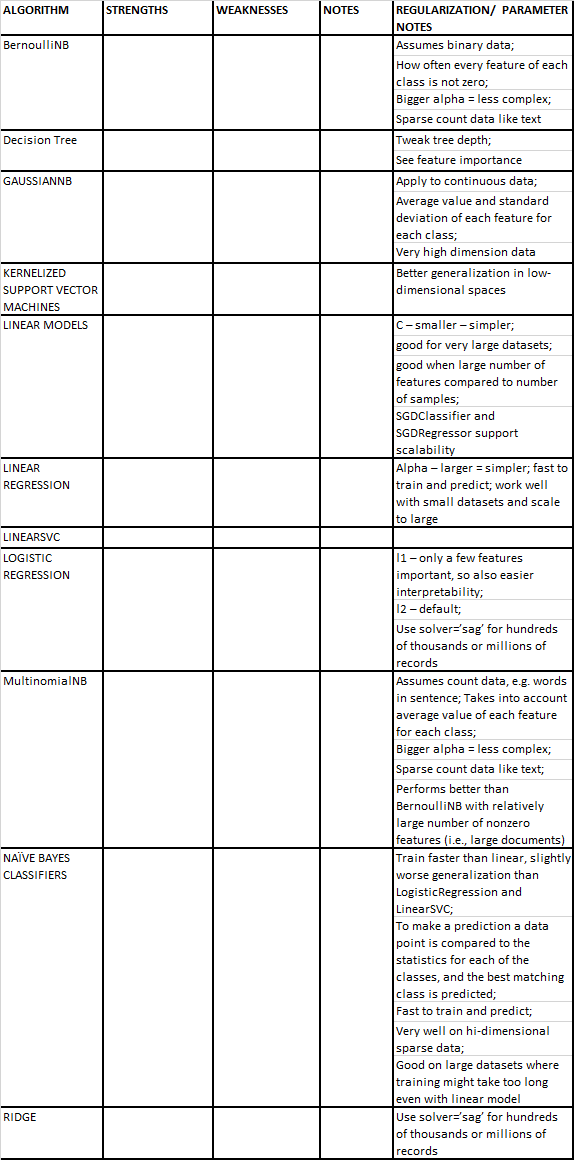

## Data Ingestion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import sklearn
import IPython
import sys
import os
import json
import time
import pickle
import requests
import pandas.io.sql as pd_sql
import sqlite3 as sql
import csv
import graphviz
from scipy import stats


from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime

from sklearn.datasets.base import Bunch

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer 
from sklearn.base import BaseEstimator, TransformerMixin 

from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import GradientBoostingClassifier 
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import KFold

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ClassBalance, ConfusionMatrix, ClassificationReport
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split as tts 

%matplotlib inline

C:\Users\Judith\Anaconda3\lib\site-packages\requests\__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.0.3) doesn't match a supported version!
  RequestsDependencyWarning)
C:\Users\Judith\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Panda settings
#Pandas will not display all columns in our data when using the head() function without this
pd.set_option('max_columns',50) 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
#this takes about 10 seconds
URL = "https://datagate.dc.gov/search/open/crimes?daterange=2years&details=true&format=csv"

def fetch_data(fname="dc-crimes-search-results.csv"):
    """
    Helper method to retrieve the ML Repository dataset.
    """
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

DATA = fetch_data()


In [4]:
def load_df(path=DATA):
    return pd.read_csv(path)

In [5]:
df = load_df()

## Data Exploration 1

In [6]:
df.columns

Index(['NEIGHBORHOOD_CLUSTER', 'CENSUS_TRACT', 'offensegroup', 'LONGITUDE',
       'END_DATE', 'offense-text', 'SHIFT', 'YBLOCK', 'DISTRICT', 'WARD',
       'YEAR', 'offensekey', 'BID', 'sector', 'PSA', 'ucr-rank', 'BLOCK_GROUP',
       'VOTING_PRECINCT', 'XBLOCK', 'BLOCK', 'START_DATE', 'CCN', 'OFFENSE',
       'ANC', 'REPORT_DAT', 'METHOD', 'location', 'LATITUDE'],
      dtype='object')

In [7]:
#summary statistics on the data.

df.describe()

,CENSUS_TRACT,LONGITUDE,YBLOCK,DISTRICT,WARD,YEAR,PSA,ucr-rank,XBLOCK,CCN,LATITUDE
count,68150.00000,68310.000000,68310.000000,68288.000000,68310.000000,68310.000000,68282.000000,68310.000000,68310.000000,6.831000e+04,68310.000000
mean,6246.37573,-77.007652,137647.594082,3.672563,4.423130,2016.850139,371.807490,6.054692,399336.910601,1.697492e+07,38.906681
std,3118.87730,0.036111,3362.312692,1.952946,2.338126,0.702458,195.112437,1.296558,3131.962109,7.695922e+05,0.030288
min,100.00000,-77.113642,127300.000000,1.000000,1.000000,2016.000000,101.000000,1.000000,390147.000000,2.111617e+06,38.813471
25%,3600.00000,-77.031224,136119.000000,2.000000,2.000000,2016.000000,206.000000,6.000000,397293.000000,1.619323e+07,38.892892
50%,7000.00000,-77.012181,137598.000000,3.000000,5.000000,2017.000000,308.000000,6.000000,398943.000000,1.708079e+07,38.906228
75%,9000.00000,-76.985441,139614.000000,5.000000,6.000000,2017.000000,506.000000,7.000000,401264.000000,1.720006e+07,38.924398
max,11100.00000,-76.910021,147292.000000,7.000000,8.000000,2018.000000,708.000000,9.000000,407806.000000,8.501717e+07,38.993560


## Data Wrangling 1 -- Parse Start Date into Month, Day, Hour

In [8]:
import datetime

In [9]:
#Create a new column with the datetime month
def label_month (row):
    startdate = (row['START_DATE'] ).replace("Z","")
    startdate2 = datetime.datetime.strptime(startdate, "%Y-%m-%dT%H:%M:%S.%f")
    return startdate2.month


In [10]:
df['start_month'] = df.apply (lambda row: label_month (row),axis=1)
#This takes about 10 seconds so wait for asterisk to disappear before proceeding

In [11]:
#Create a new column with the datetime day
def label_day (row):
    startdate = (row['START_DATE'] ).replace("Z","")
    startdate2 = datetime.datetime.strptime(startdate, "%Y-%m-%dT%H:%M:%S.%f")
    return startdate2.day


In [12]:
df['start_day'] = df.apply (lambda row: label_day (row),axis=1)
#This takes about 10 seconds so wait for asterisk to disappear before proceeding

In [13]:
#Create a new column with the datetime hour
def label_hour (row):
    startdate = (row['START_DATE'] ).replace("Z","")
    startdate2 = datetime.datetime.strptime(startdate, "%Y-%m-%dT%H:%M:%S.%f")
    return startdate2.hour


In [14]:
df['start_hour'] = df.apply (lambda row: label_hour (row),axis=1)
# This takes about 10 seconds so wait for asterisk to disappear before proceeding

In [23]:
# See new columns for start month, day, hour, positive longitude
df.columns

Index(['NEIGHBORHOOD_CLUSTER', 'CENSUS_TRACT', 'offensegroup', 'LONGITUDE',
       'END_DATE', 'offense-text', 'SHIFT', 'YBLOCK', 'DISTRICT', 'WARD',
       'YEAR', 'offensekey', 'BID', 'sector', 'PSA', 'ucr-rank', 'BLOCK_GROUP',
       'VOTING_PRECINCT', 'XBLOCK', 'BLOCK', 'START_DATE', 'CCN', 'OFFENSE',
       'ANC', 'REPORT_DAT', 'METHOD', 'location', 'LATITUDE', 'start_month',
       'start_day', 'start_hour'],
      dtype='object')

In [24]:
df.head(10)

,NEIGHBORHOOD_CLUSTER,CENSUS_TRACT,offensegroup,LONGITUDE,END_DATE,offense-text,SHIFT,YBLOCK,DISTRICT,WARD,YEAR,offensekey,BID,sector,PSA,ucr-rank,BLOCK_GROUP,VOTING_PRECINCT,XBLOCK,BLOCK,START_DATE,CCN,OFFENSE,ANC,REPORT_DAT,METHOD,location,LATITUDE,start_month,start_day,start_hour
0,cluster 32,7708.0,property,-76.955521,2016-10-04T16:37:29.000,motor vehicle theft,evening,135396.0,6.0,7,2016,property|motor vehicle theft,NaN,6D3,603.0,8,007708 2,precinct 132,403859.0,3500 - 3526 block of minnesota avenue se,2016-10-04T16:09:08.000,16168699,motor vehicle theft,7B,2016-10-05T03:00:47.000Z,others,"38.886402972929169,-76.955523453842957",38.886395,10,4,16
1,cluster 4,100.0,property,-77.059614,2016-10-04T17:44:13.000,theft/other,evening,137194.0,2.0,2,2016,property|theft/other,georgetown,2D3,206.0,6,000100 4,precinct 5,394829.0,3000 - 3029 block of k street nw,2016-10-04T17:00:48.000,16168738,theft/other,2E,2016-10-05T01:36:11.000Z,others,"38.902593275715809,-77.059616752356732",38.902585,10,4,17
2,cluster 23,8904.0,property,-76.981924,2016-10-04T20:10:43.000,theft/other,evening,136987.0,5.0,5,2016,property|theft/other,NaN,5D3,507.0,6,008904 2,precinct 79,401568.0,1500 - 1599 block of maryland avenue ne,2016-10-04T19:21:09.000,16168845,theft/other,5D,2016-10-05T02:21:19.000Z,others,"38.900742359981244,-76.981925885322667",38.900735,10,4,19
3,cluster 29,9601.0,violent,-76.937531,2016-10-14T00:12:56.000,robbery,midnight,138092.0,6.0,7,2016,violent|robbery,NaN,6D1,601.0,4,009601 1,precinct 92,405418.0,1500 1535 block of 45th street ne,2016-10-13T22:45:39.000,16174401,robbery,7D,2016-10-14T05:31:03.000Z,gun,"38.910681288493713,-76.937533164068512",38.910673,10,13,22
4,cluster 25,10600.0,violent,-76.995538,2016-10-22T16:40:05.000,robbery,evening,137463.0,5.0,6,2016,violent|robbery,NaN,5D3,506.0,4,010600 1,precinct 83,400387.0,700 - 799 block of florida avenue ne,2016-10-22T16:24:12.000,16180021,robbery,6C,2016-10-22T22:55:30.000Z,gun,"38.90503165003841,-76.995540557600265",38.905024,10,22,16
5,cluster 2,3200.0,property,-77.021405,2016-10-22T22:56:31.000,theft f/auto,midnight,140137.0,3.0,1,2016,property|theft f/auto,NaN,3D1,302.0,7,003200 4,precinct 38,398144.0,500 - 699 block of irving street nw,2016-10-22T20:21:52.000,16180127,theft f/auto,1A,2016-10-24T04:29:28.000Z,others,"38.929118054612083,-77.021407353091945",38.929110,10,22,20
6,cluster 31,7807.0,property,-76.922953,NaN,theft/other,midnight,137294.0,6.0,7,2016,property|theft/other,NaN,6D1,608.0,6,007807 2,precinct 95,406683.0,934 - 1099 block of eastern avenue ne,2016-10-22T21:53:20.000,16180199,theft/other,7C,2016-10-23T04:11:28.000Z,others,"38.903483920886075,-76.922955583391357",38.903476,10,22,21
7,cluster 6,10700.0,property,-77.040088,2016-10-23T04:28:53.000,theft f/auto,midnight,137847.0,2.0,2,2016,property|theft f/auto,NaN,2D3,208.0,7,010700 2,precinct 15,396523.0,1700 - 1799 block of massachusetts avenue nw,2016-10-23T01:30:55.000,16180348,theft f/auto,2B,2016-10-23T09:24:07.000Z,others,"38.908484062358717,-77.040090587782586",38.908476,10,23,1
8,cluster 17,1804.0,property,-77.031560,2016-10-23T06:00:06.000,theft f/auto,day,144484.0,4.0,4,2016,property|theft f/auto,NaN,4D1,402.0,7,001804 1,precinct 61,397265.0,1300 - 1399 block of tewkesbury place nw,2016-10-22T09:00:04.000,16180372,theft f/auto,4A,2016-10-23T11:46:17.000Z,others,"38.968274741325793,-77.031562108374985",38.968267,10,22,9
9,cluster 26,7000.0,property,-76.996185,2016-11-01T10:00:39.000,theft f/auto,day,134740.0,1.0,6,2016,property|theft f/auto,NaN,1D3,106.0,7,007000 1,precinct 90,400331.0,700 - 753 block of 7th street se,2016-11-01T08:30:07.000,16186247,theft f/auto,6B,2016-11-01T15:26:46.000Z,others,"38.880501876434913,-76.996187492452577",38.880494,11,1,8


## Data Exploration 2 - UCR Rank

Look at ucrrank (Uniform Crime Report Rank). DC uses this index (1-9) to rank crime severity. This is how the ucrrank relates to crime detail: 

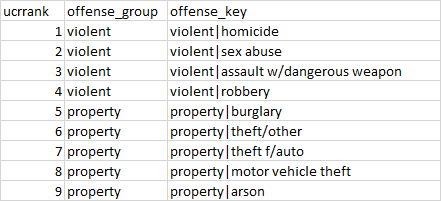

Notice that a ucrrank of 1 is assigned to the most serious type of crime and 9 to the least serious.  

In [25]:
# Use pandas to get the median of the ucrrank column. DataFrame.median(axis=None, skipna=None, level=None, numeric_only=None, **kwargs)[source]
df['ucr-rank'].median()

6.0

In [26]:
# Use pandas to find the number of unique values in the ucrrank column. Series.nunique(dropna=True)[source]¶
df['ucr-rank'].nunique()

9

In [27]:
df.dtypes

NEIGHBORHOOD_CLUSTER     object
CENSUS_TRACT            float64
offensegroup             object
LONGITUDE               float64
END_DATE                 object
offense-text             object
SHIFT                    object
YBLOCK                  float64
DISTRICT                float64
WARD                      int64
YEAR                      int64
offensekey               object
BID                      object
sector                   object
PSA                     float64
ucr-rank                  int64
BLOCK_GROUP              object
VOTING_PRECINCT          object
XBLOCK                  float64
BLOCK                    object
START_DATE               object
CCN                       int64
OFFENSE                  object
ANC                      object
REPORT_DAT               object
METHOD                   object
location                 object
LATITUDE                float64
start_month               int64
start_day                 int64
start_hour                int64
dtype: o

In [28]:
# Use pandas to count the number of each unique ucrrank value.
df['ucr-rank'].value_counts()

6    28856
7    21702
8     5011
4     4647
3     3854
5     3339
2      632
1      259
9       10
Name: ucr-rank, dtype: int64

## Visualize the Data
Now let's look at two histograms of the ```Fare``` data. In the first, we'll set ```bins=10``` and in the second ```bin=50```. Which one do you find the most helpful? What are you able to tell about the range of fares paid by the passengers from the histograms?

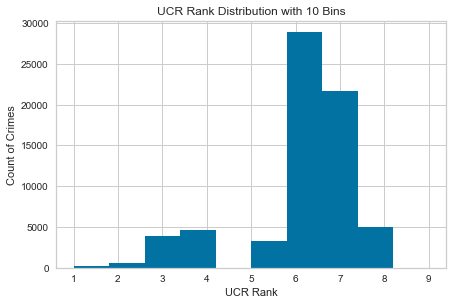

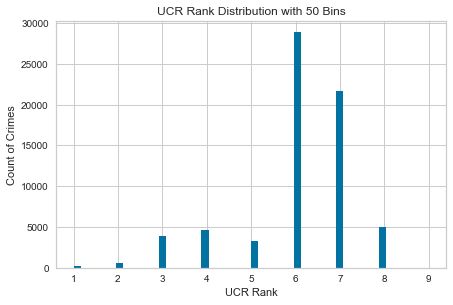

In [29]:
fig = plt.figure(figsize=(7,10))
ax = fig.add_subplot(211)
ax.hist(df['ucr-rank'], bins=10, range=(df['ucr-rank'].min(),df['ucr-rank'].max()))
plt.title('UCR Rank Distribution with 10 Bins')
plt.xlabel('UCR Rank')
plt.ylabel('Count of Crimes')
plt.show()

fig = plt.figure(figsize=(7,10))
ax = fig.add_subplot(212)
ax.hist(df['ucr-rank'], bins=50, range=(df['ucr-rank'].min(),df['ucr-rank'].max()))
plt.title('UCR Rank Distribution with 50 Bins')
plt.xlabel('UCR Rank')
plt.ylabel('Count of Crimes')
plt.show()

## Delete Features

Reduce dataframe to only numerics as required for machine learning. I will review the deletions in the future in case it would help to convert some categorical features like offense and offense group in future versions.  

Delete all columns listed as objects:  
NEIGHBORHOOD_CLUSTER     object
CENSUS_TRACT            float64
offensegroup             object
LONGITUDE               float64
END_DATE                 object
offense-text             object
SHIFT                    object
YBLOCK                  float64
DISTRICT                float64
WARD                      int64
YEAR                      int64
offensekey               object
BID                      object
sector                   object
PSA                     float64
ucr-rank                  int64
BLOCK_GROUP              object
VOTING_PRECINCT          object
XBLOCK                  float64
BLOCK                    object
START_DATE               object
CCN                       int64
OFFENSE                  object
ANC                      object
REPORT_DAT               object
METHOD                   object
location                 object
LATITUDE                float64
start_month               int64
start_day                 int64
start_hour                int64
dtype: object

That includes:  NEIGHBORHOOD_CLUSTER, offensegroup, END_DATE, offense-text, SHIFT, offensekey, BID, sector, BLOCK_GROUP, VOTING_PRECINCT, BLOCK, START_DAT, OFFENSE, ANC, REPORT_DAT, METHOD, location

In [37]:
df2 = df.drop(['CCN', 'NEIGHBORHOOD_CLUSTER', 'offensegroup', 'END_DATE', 'offense-text', 'SHIFT', 'offensekey', 'BID', 'sector', 'BLOCK_GROUP', 'VOTING_PRECINCT', 'BLOCK', 'START_DATE', 'OFFENSE', 'ANC', 'REPORT_DAT', 'METHOD', 'location'], axis=1)

In [38]:
df2.dtypes

CENSUS_TRACT    float64
LONGITUDE       float64
YBLOCK          float64
DISTRICT        float64
WARD              int64
YEAR              int64
PSA             float64
ucr-rank          int64
XBLOCK          float64
LATITUDE        float64
start_month       int64
start_day         int64
start_hour        int64
dtype: object

In [36]:
df2.head(10)

,CENSUS_TRACT,LONGITUDE,YBLOCK,DISTRICT,WARD,YEAR,PSA,ucr-rank,XBLOCK,CCN,LATITUDE,start_month,start_day,start_hour
0,7708.0,-76.955521,135396.0,6.0,7,2016,603.0,8,403859.0,16168699,38.886395,10,4,16
1,100.0,-77.059614,137194.0,2.0,2,2016,206.0,6,394829.0,16168738,38.902585,10,4,17
2,8904.0,-76.981924,136987.0,5.0,5,2016,507.0,6,401568.0,16168845,38.900735,10,4,19
3,9601.0,-76.937531,138092.0,6.0,7,2016,601.0,4,405418.0,16174401,38.910673,10,13,22
4,10600.0,-76.995538,137463.0,5.0,6,2016,506.0,4,400387.0,16180021,38.905024,10,22,16
5,3200.0,-77.021405,140137.0,3.0,1,2016,302.0,7,398144.0,16180127,38.929110,10,22,20
6,7807.0,-76.922953,137294.0,6.0,7,2016,608.0,6,406683.0,16180199,38.903476,10,22,21
7,10700.0,-77.040088,137847.0,2.0,2,2016,208.0,7,396523.0,16180348,38.908476,10,23,1
8,1804.0,-77.031560,144484.0,4.0,4,2016,402.0,7,397265.0,16180372,38.968267,10,22,9
9,7000.0,-76.996185,134740.0,1.0,6,2016,106.0,7,400331.0,16186247,38.880494,11,1,8


In [39]:
#Change column order to put ucr-rank (target) last

df3 = df2.reindex(columns=["CENSUS_TRACT", "LONGITUDE", "YBLOCK", "DISTRICT", "WARD", "YEAR", "PSA", "XBLOCK", "LATITUDE", "start_month", "start_day", "start_hour", "ucr-rank"])

In [41]:
df3.head(10)

,CENSUS_TRACT,LONGITUDE,YBLOCK,DISTRICT,WARD,YEAR,PSA,XBLOCK,LATITUDE,start_month,start_day,start_hour,ucr-rank
0,7708.0,-76.955521,135396.0,6.0,7,2016,603.0,403859.0,38.886395,10,4,16,8
1,100.0,-77.059614,137194.0,2.0,2,2016,206.0,394829.0,38.902585,10,4,17,6
2,8904.0,-76.981924,136987.0,5.0,5,2016,507.0,401568.0,38.900735,10,4,19,6
3,9601.0,-76.937531,138092.0,6.0,7,2016,601.0,405418.0,38.910673,10,13,22,4
4,10600.0,-76.995538,137463.0,5.0,6,2016,506.0,400387.0,38.905024,10,22,16,4
5,3200.0,-77.021405,140137.0,3.0,1,2016,302.0,398144.0,38.929110,10,22,20,7
6,7807.0,-76.922953,137294.0,6.0,7,2016,608.0,406683.0,38.903476,10,22,21,6
7,10700.0,-77.040088,137847.0,2.0,2,2016,208.0,396523.0,38.908476,10,23,1,7
8,1804.0,-77.031560,144484.0,4.0,4,2016,402.0,397265.0,38.968267,10,22,9,7
9,7000.0,-76.996185,134740.0,1.0,6,2016,106.0,400331.0,38.880494,11,1,8,7


In [42]:
print(df3.shape)

(68310, 13)


## Save to text file and csv file

In [43]:
filename = 'crime.csv'
df3.to_csv(filename, index = False)

In [44]:
filename = 'crime.txt'
np.savetxt(filename, df3.values, fmt='%s')

In [45]:
df3.columns

Index(['CENSUS_TRACT', 'LONGITUDE', 'YBLOCK', 'DISTRICT', 'WARD', 'YEAR',
       'PSA', 'XBLOCK', 'LATITUDE', 'start_month', 'start_day', 'start_hour',
       'ucr-rank'],
      dtype='object')

In [50]:
crime_ML = df3.replace([np.inf, -np.inf], np.nan)

In [51]:
crime_ML = crime_ML .dropna()

In [62]:
crime_ML.shape
#Lost 188 records with nulls or infinity values

(68122, 13)

In [66]:
print(crime_ML.shape)

(68122, 13)


## Save to text file and csv file

In [68]:
crime_ML.head(10)

,CENSUS_TRACT,LONGITUDE,YBLOCK,DISTRICT,WARD,YEAR,PSA,XBLOCK,LATITUDE,start_month,start_day,start_hour,ucr-rank
0,7708.0,-76.955521,135396.0,6.0,7,2016,603.0,403859.0,38.886395,10,4,16,8
1,100.0,-77.059614,137194.0,2.0,2,2016,206.0,394829.0,38.902585,10,4,17,6
2,8904.0,-76.981924,136987.0,5.0,5,2016,507.0,401568.0,38.900735,10,4,19,6
3,9601.0,-76.937531,138092.0,6.0,7,2016,601.0,405418.0,38.910673,10,13,22,4
4,10600.0,-76.995538,137463.0,5.0,6,2016,506.0,400387.0,38.905024,10,22,16,4
5,3200.0,-77.021405,140137.0,3.0,1,2016,302.0,398144.0,38.929110,10,22,20,7
6,7807.0,-76.922953,137294.0,6.0,7,2016,608.0,406683.0,38.903476,10,22,21,6
7,10700.0,-77.040088,137847.0,2.0,2,2016,208.0,396523.0,38.908476,10,23,1,7
8,1804.0,-77.031560,144484.0,4.0,4,2016,402.0,397265.0,38.968267,10,22,9,7
9,7000.0,-76.996185,134740.0,1.0,6,2016,106.0,400331.0,38.880494,11,1,8,7


In [70]:
filename = 'crime_ML.csv'
crime_ML.to_csv(filename, index = False)

In [71]:
filename = 'crime_ML.txt'
np.savetxt(filename, crime_ML.values, fmt='%s') 

In [73]:
print(crime_ML.columns)

Index(['CENSUS_TRACT', 'LONGITUDE', 'YBLOCK', 'DISTRICT', 'WARD', 'YEAR',
       'PSA', 'XBLOCK', 'LATITUDE', 'start_month', 'start_day', 'start_hour',
       'ucr-rank'],
      dtype='object')


In [74]:
print(crime_ML.shape)

(68122, 13)


In [76]:
crime_ML.head(10)

,CENSUS_TRACT,LONGITUDE,YBLOCK,DISTRICT,WARD,YEAR,PSA,XBLOCK,LATITUDE,start_month,start_day,start_hour,ucr-rank
0,7708.0,-76.955521,135396.0,6.0,7,2016,603.0,403859.0,38.886395,10,4,16,8
1,100.0,-77.059614,137194.0,2.0,2,2016,206.0,394829.0,38.902585,10,4,17,6
2,8904.0,-76.981924,136987.0,5.0,5,2016,507.0,401568.0,38.900735,10,4,19,6
3,9601.0,-76.937531,138092.0,6.0,7,2016,601.0,405418.0,38.910673,10,13,22,4
4,10600.0,-76.995538,137463.0,5.0,6,2016,506.0,400387.0,38.905024,10,22,16,4
5,3200.0,-77.021405,140137.0,3.0,1,2016,302.0,398144.0,38.929110,10,22,20,7
6,7807.0,-76.922953,137294.0,6.0,7,2016,608.0,406683.0,38.903476,10,22,21,6
7,10700.0,-77.040088,137847.0,2.0,2,2016,208.0,396523.0,38.908476,10,23,1,7
8,1804.0,-77.031560,144484.0,4.0,4,2016,402.0,397265.0,38.968267,10,22,9,7
9,7000.0,-76.996185,134740.0,1.0,6,2016,106.0,400331.0,38.880494,11,1,8,7


In [78]:
crime_ML.dtypes

CENSUS_TRACT    float64
LONGITUDE       float64
YBLOCK          float64
DISTRICT        float64
WARD              int64
YEAR              int64
PSA             float64
XBLOCK          float64
LATITUDE        float64
start_month       int64
start_day         int64
start_hour        int64
ucr-rank          int64
dtype: object

# Machine Learning Exploration

## Load the text file and create the bunch object

In [ ]:
from numpy import genfromtxt
def load_data():
    # Construct the `Bunch` for the crime_census dataset
    filenames     = {
        'meta': 'meta.json',
        'rdme': 'README.md',
        'data': 'crime_census_ML.csv',
    }

    # Load the meta data from the meta json
    with open(filenames['meta'], 'r') as f:
        meta = json.load(f)
        target_names  = meta['target_names']
        feature_names = meta['feature_names']

    # Load the description from the README. 
    with open(filenames['rdme'], 'r') as f:
        DESCR = f.read()

    # Load the dataset from the text file.
#    dataset = np.loadtxt(filenames['data'])
    dataset = genfromtxt(filenames['data'], delimiter=',', skip_header=1, usecols=range(1,17))

    # Extract the target from the data
    data   = dataset[:, 0:-1]
    target = dataset[:, -1]
    


    # Create the bunch object
    return Bunch(
        data=data,
        target=target,
        filenames=filenames,
        target_names=target_names,
        feature_names=feature_names,
        DESCR=DESCR
    )

# Save the dataset as a variable we can use.
dataset = load_data()

print(dataset.data.shape)
print(dataset.target.shape)

In [ ]:
print("Feature names:\n{}".format(dataset['feature_names']))

In [ ]:
print("Target names:\n{}".format(dataset['target_names']))

## Classification

In [ ]:
def fit_and_evaluate(dataset, model, label, **kwargs):
    """
    Because of the Scikit-Learn API, we can create a function to
    do all of the fit and evaluate work on our behalf!
    """
    start  = time.time() # Start the clock! 
    #scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    scores = {'f1':[]}
    
    for train, test in KFold(dataset.data.shape[0], n_folds=12, shuffle=True):
        X_train, X_test = dataset.data[train], dataset.data[test]
        y_train, y_test = dataset.target[train], dataset.target[test]
        
        estimator = model(**kwargs)
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        #scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        #scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        #scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))

    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(dataset.data, dataset.target)
    
    outpath = label.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)

    print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))

In [ ]:
pd.to_datetime('today')# Perform kNN Classification
fit_and_evaluate(dataset, KNeighborsClassifier, "Crime kNN Classifier", n_neighbors=12)

In [ ]:
fit_and_evaluate(dataset, LogisticRegression, "Logistic Regression")

In [ ]:
fit_and_evaluate(dataset, GaussianNB, "Gaussian NB")

In [ ]:
fit_and_evaluate(dataset, RandomForestClassifier, "RandomForestClassifier")

In [ ]:
# Perform SVC Classification
#fit_and_evaluate(dataset, SVC, "Crime SVM Classifier")